## RNN Time Series Implementation

In [3]:
# Importing the Libraries
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [6]:
# Data from Federal Reserve Economic Database (FRED)[https://fred.stlouisfed.org/]
filename = 'Data/Alcohol_sales.csv'

In [7]:
df = pd.read_csv(filename, index_col = 0, parse_dates = True)

In [10]:
df.head()
# monthly increments

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [15]:
df = df.dropna()

In [14]:
len(df)

325

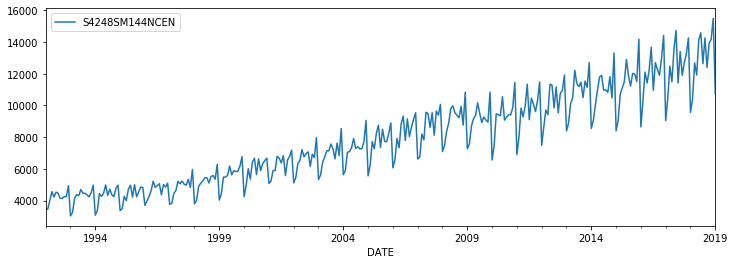

In [17]:
df.plot(figsize = (12, 4))
# clear seasonality 
# general upward trend

In [18]:
y = df['S4248SM144NCEN'].values.astype(float)

In [20]:
# Using 1 year as a test size
test_size = 12

In [22]:
train = y[:-test_size]
test = y[-test_size:]

In [27]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
train_norm = scaler.fit_transform(train.reshape(-1,1))

In [30]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [31]:
# Hyperparams
seq_size = 12

In [36]:
# prepare data for LSTM
def prep_data(seq, ss):
    output = []
    l = len(seq)
    
    for i in range(l - ss):
        data = seq[i:i+ss]
        label = seq[i+ss:i+ss+1]
        output.append((data,label))
    
    return output

In [37]:
train_data = prep_data(train_norm, seq_size)

In [38]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))